# Non-linear SVM: idea for Federated Setting

In the present notebook, the idea for a Federated non-linear support vector machine (SVM) classification is presented. 
The model is encapsulated in the Sherpa.ai Federated Learning Framework on for a synthetic database.
Moreover, differential privacy is applied and its impact on the global model is assessed. 

We start by creating a synthetic database: 

In [1]:
import shfl
from shfl.data_base.data_base import LabeledDatabase
from sklearn.datasets import make_classification
import numpy as np

# Create database:
n_features = 2
n_classes = 3
data, labels = make_classification(
    n_samples=400, n_features=n_features, n_informative=2, 
    n_redundant=0, n_repeated=0, n_classes=n_classes, 
    n_clusters_per_class=1, weights=None, flip_y=0.1, class_sep=0.1)
database = LabeledDatabase(data, labels)

train_data, train_labels, test_data, test_labels = database.load_data()

# Specify model params:
# if using NuSVC:
#nu = 0.5 
#kwargs = {'nu':nu}
# if using SVC:
C = 1
kwargs = {'C':C}

In [2]:
print("Shape of train and test data: " + str(train_data.shape) + str(test_data.shape))
print("Shape of train and test labels: " + str(train_labels.shape) + str(test_labels.shape))
print(train_data[0,:])

Shape of train and test data: (320, 2)(80, 2)
Shape of train and test labels: (320,)(80,)
[-0.32156598 -0.55683207]


Next, we define the new class for SVM using [`sklearn`'s Support Vector Machine classifers](https://scikit-learn.org/stable/modules/svm.html).
By the implementation below, you can use either `SVC` or `NuSVC`:

In [3]:
from shfl.model.model import TrainableModel
import numpy as np
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn import metrics


class SVMClassifierModel(TrainableModel):
    """
    This class offers support for scikit-learn SVM non-linear classification. It implements [TrainableModel](../Model/#trainablemodel-class)

    # Arguments:
        n_features: integer number of features (independent variables).
        classes: array of classes to predict. At least 2 classes must be provided.
        model_inputs: optional dictionary containing the model input parameters
        model: model to employ. Options are [NuSVC (default)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html)
    """
    def __init__(self, n_features, classes, model_inputs=None, model=None):
        if model is None:
            model = SVC
        if model_inputs is None:
            model_inputs = {}
        self._check_initialization(n_features, classes)
        self._model = model(**model_inputs)
        self._n_features = n_features
        classes = np.sort(np.asarray(classes))
        self._model.classes_ = classes
        n_classes = len(classes)
        params = np.column_stack((np.zeros((n_classes, n_features)), range(len(classes)) )) 
        self.set_model_params(params)
        
    def train(self, data, labels):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)

        # Arguments
            data: Data, array-like of shape (n_samples, n_features)
            labels: Target classes, array-like of shape (n_samples,) 
        """
        self._check_data(data)
        self._check_labels_train(labels)
        
        self._model.fit(data, labels)

    def predict(self, data):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)

        Arguments:
            data: Data, array-like of shape (n_samples, n_features)
        """
        prediction = self._model.predict(data)
        
        return prediction
    
    def evaluate(self, data, labels):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)
        Metrics for evaluating model's performance.
        
        Arguments:
            data: Data, array-like of shape (n_samples, n_features)
            labels: Target classes, array-like of shape (n_samples,) 
        """
        self._check_data(data)
        self._check_labels_predict(labels)
        
        prediction = self.predict(data)
        bas = metrics.balanced_accuracy_score(labels, prediction)
        cks = metrics.cohen_kappa_score(labels, prediction)
        
        return bas, cks
    
    def performance(self, data, labels):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)
        
        Arguments:
            data: Data, array-like of shape (n_samples, n_features)
            labels: Target classes, array-like of shape (n_samples,) 
        """
        self._check_data(data)
        self._check_labels_predict(labels)
        
        prediction = self.predict(data)
        bas = metrics.balanced_accuracy_score(labels, prediction)
        
        return bas

    def get_model_params(self):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)
        """
        classes_index = [np.full(i_nSV, i_class) for (i_class, i_nSV) in 
                  zip(range(len(self._model.classes_)), self._model.n_support_)]
        classes_index = np.hstack(classes_index)
        params = np.column_stack((self._model.support_vectors_, classes_index))
        params = params.astype(self._model.support_vectors_.dtype)
        
        return params

    def set_model_params(self, params):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)
        """
        self._model.support_vectors_ = np.ascontiguousarray(params[:, 0:-1], dtype=params.dtype)
        labels = params[:,-1]
        n_support = [np.sum(labels == i_class) for i_class in range(len(self._model.classes_))]
        self._model._n_support = np.asarray(n_support, dtype=np.int32)

    def _check_data(self, data):
        """
        Method that checks whether the data dimension is correct.
        """
        data = np.asarray(data)
        if data.ndim == 1:
            if self._n_features != 1:
                raise AssertionError("Data need to have the same number of features described by the model, " + str(self._n_features)
                                     + ". Current data have only 1 feature.")
        elif data.shape[1] != self._n_features:
            raise AssertionError("Data need to have the same number of features described by the model, " + str(self._n_features) +
                                 ". Current data has " + str(data.shape[1]) + " features.")

    def _check_labels_train(self, labels):
        """
        Method that checks whether the classes are correct. 
        When training, the classes in client's data must be the same as the input ones.
        
        # Arguments:
            labels: array with classes
        """
        classes = np.unique(np.asarray(labels))
        if not np.array_equal(self._model.classes_, classes):
            raise AssertionError("When training, labels need to have the same classes described by the model, " + str(self._model.classes_)
                                 + ". Labels of this node are " + str(classes) + " .")
            
    def _check_labels_predict(self, labels):
        """
        Method that checks whether the classes are correct. 
        When predicting, the classes in data must be a subset of the trained ones.
        
        # Arguments:
            labels: array with classes
        """
        classes = np.unique(np.asarray(labels))
        if not set(classes) <= set(self._model.classes_):
            raise AssertionError("When predicting, labels need to be a subset of the classes described by the model, " + str(self._model.classes_)
                                 + ". Labels in the given data are " + str(classes) + " .")
    @staticmethod
    def _check_initialization(n_features, classes):
        """
        Method that checks if model's initialization is correct. 
        The number of features must be an integer equal or greater to one, and there must be at least two classes.

        # Arguments:
            n_features: number of features
            classes: array of classes to predict
        """
        if not isinstance(n_features, int):
            raise AssertionError("n_features must be a positive integer number. Provided " + str(n_features) + " features.")
        if n_features < 0:
            raise AssertionError("It must verify that n_features > 0. Provided value " + str(n_features) + ".")
        if len(classes) < 2:
            raise AssertionError("It must verify that the number of classes > 1. Provided " + str(len(classes)) + " classes.")
        if len(np.unique(classes)) != len(classes):
            classes = list(classes)
            duplicated_classes = [i_class for i_class in classes if classes.count(i_class) > 1]
            raise AssertionError("No duplicated classes allowed. Class(es) duplicated: " + str(duplicated_classes) )



In [4]:
import matplotlib.pyplot as plt


def plot_2D_decision_boundary(model, data, labels, title=None):
    # Step size of the mesh. Smaller it is, better the quality
    h = .02 
    # Color map
    cmap = plt.cm.Set1
    
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(9,6))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap,
               alpha=0.6,
               aspect='auto', origin='lower')
    # Plot data:
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap, s=40, marker='o')
    
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

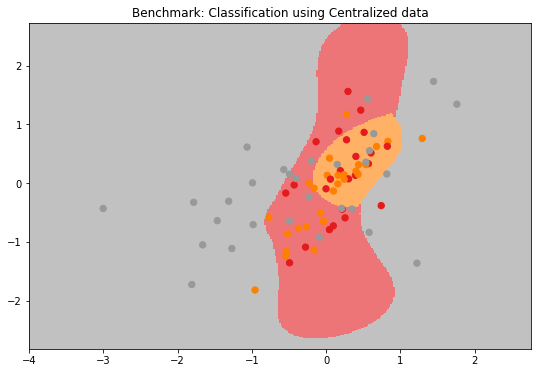

Test performance using centralized data: (0.511068539804172, 0.27458730527784236)


In [5]:
# Train global model using framework's class: 
classes = [i for i in range(0,n_classes)] 
model_centralized = SVMClassifierModel(n_features=n_features, classes=classes, model_inputs=kwargs)
model_centralized.train(data=train_data, labels=train_labels)
if n_features == 2:
    plot_2D_decision_boundary(model_centralized, test_data, labels=test_labels, title = "Benchmark: Classification using Centralized data")
print("Test performance using centralized data: " + str(model_centralized.evaluate(test_data, test_labels)))

## Aggregation problem
`sklearn` provides three options for classification: `LinearSVC`, `SVC` and `NuSVC`. 
The linear version `LinearSVC` is easily incorporated in the platform, since the aggregation of the model is strightforward. 
Instead, for `SVC` and `NuSVC`, the output model's parameters are more complex, since they depend on the number of support vectors for each class. 
Thus, in principle, each client would deliver parameters with different dimensions, which are not straightforward to aggregate. 

Here, we use the clients' support vectors to *train a global model directly on the server*, obtaining the aggregated model: 

In [6]:
import numpy as np
import inspect


from shfl.federated_aggregator.federated_aggregator import FederatedAggregator

class GlobalModelAggregator(FederatedAggregator):
    """
    Trains the global model over the local parameters to aggregate them.

    It implements [Federated Aggregator](../federated_aggregator/#federatedaggregator-class)
    """

    def aggregate_weights(self, clients_params):
        """
        Implementation of abstract method of class [AggregateWeightsFunction](../federated_aggregator/#federatedaggregator-class)
        # Arguments:
            clients_params: list of multi-dimensional (numeric) arrays. Each entry in the list contains the model's parameters of one client.

        # Returns
            aggregated_weights: aggregator weights representing the global learning model

        # References
            [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://arxiv.org/abs/1602.05629)
        """
        caller_object = inspect.currentframe().f_back.f_locals['self']
        #print(type(caller_object.global_model).__name__)
        clients_params_array = np.vstack(clients_params)
        caller_object.global_model.train(clients_params_array[:, 0:-1], clients_params_array[:, -1])
        aggregated_weights = caller_object.global_model.get_model_params()

        return aggregated_weights

Once defined the aggregator, we can run the federated model as usual.
Note that the decision boundary can vary even by running the training on the same data (this is due to the internal shuffle of the data of the SVM solver). 
Thus, in order to compare the centralized and the federated models, it is more relevant to compare the scores on the test data:

Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe2e4a90>: (0.49270966368667524, 0.2361900431916345)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe2e4dd8>: (0.4697211579395488, 0.20664206642066418)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30b630>: (0.4211898680289485, 0.1369606003752346)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30bd68>: (0.4493401447424436, 0.18925288710817811)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30b390>: (0.48552575564069816, 0.23972440009503437)
Global model test performance : (0.511068539804172, 0.27458730527784236)





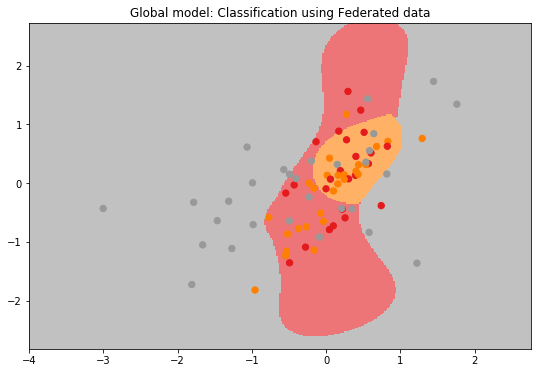

Model used: SVC


In [7]:
#np.random.seed(132)     # Reproducibility
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_labels = iid_distribution.get_federated_data(num_nodes=5, percent=100)

classes = [i for i in range(0,n_classes)] 
def model_builder():
    model = SVMClassifierModel(n_features=n_features, classes=classes, model_inputs=kwargs)
    return model

aggregator = GlobalModelAggregator()

federated_government = shfl.federated_government.FederatedGovernment(model_builder, federated_data, aggregator)
federated_government.run_rounds(n=1, test_data=test_data, test_label=test_labels)

if n_features == 2:
    plot_2D_decision_boundary(federated_government.global_model, test_data, test_labels, title = "Global model: Classification using Federated data")

print("Model used: " + type(federated_government.global_model._model).__name__)

## Adding Differential Privacy

In instance-based machine learning methods such as SVM or KNN, part of the data (or the entire data, in the worst case) constitute the resulting model. 
These methods are thus particularly exposed to reconstruction attacks (e.g. see [Yang et al. 2019](https://www.morganclaypool.com/doi/pdf/10.2200/S00960ED2V01Y201910AIM043)). 
In order to protect private information, we can apply Differential Privacy on the resulting model output from the clients and observe its influence on the federated global model. 

### Sensitivity by sampling:
We first estimate model's sensitivity by sampling.
Recall that the matrices of support vectors are the actual models' parameters, and that they can have differying number of rows.
We then need to define a distance between such matrices: we can choose the max of the distance of their rows (see [matrix distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html)).

Note that, due to the internal data shuffle, the SVM solver can deliver slightly different support vectors even when training on very similar data (even when setting the random seed (see [`random_state` input parameter](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)). 
As a matter of fact, in the sensitivity sampling, we consider databases that differ at most in one entry, or contain exactly the same data, yet some of the support vectors turn out to be different.
Thus, the resulting sensitivity is then particularly high, and the application of DP dramatically deteriorates the performance of the global model:

In [8]:
from shfl.differential_privacy import SensitivitySampler
from shfl.differential_privacy import L1SensitivityNorm
from shfl.differential_privacy import SensitivityNorm
from scipy.spatial import distance_matrix
 
class UniformDistribution(shfl.differential_privacy.ProbabilityDistribution):
    """
    Implement Uniform sampling over the data
    """
    def __init__(self, sample_data):
        self._sample_data = sample_data

    def sample(self, sample_size):
        row_indices = np.random.choice(a=self._sample_data.shape[0], size=sample_size, replace=False)
        
        return self._sample_data[row_indices, :]
    
    
class SVMClassifierSample(SVMClassifierModel):
    
    def get(self, data_array):
        data = data_array[:, 0:-1]
        labels = data_array[:, -1]
        train_model = self.train(data, labels)
        model_params = self.get_model_params()
        model_params = model_params[:,0:-1] # Exclude the classes indices
        
        return model_params.copy()


class MatrixSetXoRNorm(SensitivityNorm):
    """
    Implements L1 norm only using rows not in common.
    """
    def compute(self, x_1, x_2):
        nrows, ncols = x_1.shape
        dtype = {'names':['f{}'.format(i) for i in range(ncols)],
                   'formats':ncols * [x_1.dtype]}
        x = np.setxor1d(x_1.view(dtype), x_2.view(dtype))
        x = x.view(x_1.dtype).reshape(-1, ncols)
        if x.shape[0] is not 0:
            x = distance_matrix(x,x)
            x = x.max()
        else:
            x = 0

        return x

In [9]:
# Create sampling database:
n_instances = 400
sampling_data, sampling_labels = make_classification(
    n_samples=n_instances, n_features=n_features, n_informative=2, 
    n_redundant=0, n_repeated=0, n_classes=n_classes, 
    n_clusters_per_class=1, weights=None, flip_y=0.1, class_sep=0.1)  
sample_data = np.hstack((sampling_data, sampling_labels.reshape(-1,1)))

# Sampling sensitivity:
distribution = UniformDistribution(sample_data)
sampler = SensitivitySampler()

n_samples = 200 # must be <= n_instances
kwargs['random_state'] = 123
kwargs['C'] = 1
max_sensitivity, mean_sensitivity = sampler.sample_sensitivity(
    SVMClassifierSample(n_features=n_features, classes=classes, model_inputs=kwargs), 
    MatrixSetXoRNorm(), distribution, n=n_samples, m=100)

print("Max sensitivity from sampling: " + str(max_sensitivity))
print("Mean sensitivity from sampling: " + str(mean_sensitivity))

Max sensitivity from sampling: 3.9537433519275904
Mean sensitivity from sampling: 1.0378818386180253


Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe2e4a90>: (0.49270966368667524, 0.2361900431916345)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe2e4dd8>: (0.4697211579395488, 0.20664206642066418)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30b630>: (0.4211898680289485, 0.1369606003752346)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30bd68>: (0.4493401447424436, 0.18925288710817811)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30b390>: (0.48552575564069816, 0.23972440009503437)
Global model test performance : (0.31704980842911873, -0.02288021534320328)





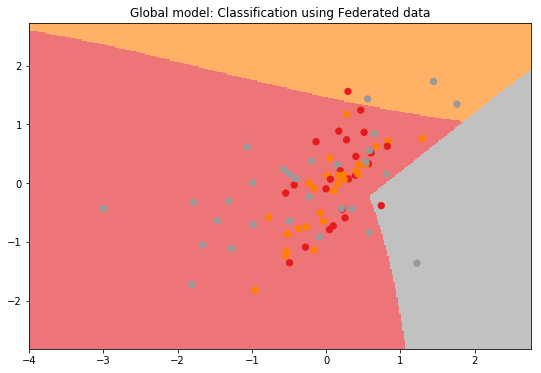

Model used: SVC


In [10]:
from shfl.differential_privacy import LaplaceMechanism

sensitivity_array = np.full((n_features+1,), max_sensitivity)
sensitivity_array[-1] = 0  # We don't apply noise on the classes
params_access_definition = LaplaceMechanism(sensitivity=sensitivity_array, epsilon=1)
federated_governmentDP = shfl.federated_government.FederatedGovernment(
    model_builder, federated_data, aggregator, model_params_access=params_access_definition)

federated_governmentDP.run_rounds(n=1, test_data=test_data, test_label=test_labels)
if n_features == 2:
    plot_2D_decision_boundary(federated_governmentDP.global_model, test_data, test_labels, title = "Global model: Classification using Federated data")

print("Model used: " + type(federated_governmentDP.global_model._model).__name__)

### Sensitivity associated to the data: 
Since the SVM's parameters are constituted by the data itself, we might assume that the model's sensitivity is actually the sensitivity to apply on the data itself if one would try to access it (see [Laplace mechanism notebook](../differential_privacy/differential_privacy_laplace.ipynb)). 
We then take the component-wise variance of the data as the sensitvity. 
The resulting $\epsilon$-private global model's performance is then comparable to the non-private version:

Component-wise sensitivity: [0.41424281 0.53702762 0.        ]
Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe2e4a90>: (0.49270966368667524, 0.2361900431916345)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe2e4dd8>: (0.4697211579395488, 0.20664206642066418)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30b630>: (0.4211898680289485, 0.1369606003752346)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30bd68>: (0.4493401447424436, 0.18925288710817811)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7faabe30b390>: (0.48552575564069816, 0.23972440009503437)
Global model test performance : (0.4311409110259685, 0.15828851999064764)





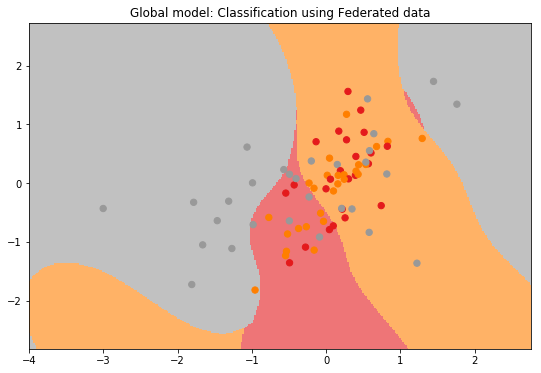

Model used: SVC


In [11]:
from shfl.differential_privacy import LaplaceMechanism

sensitivity_array = np.var(sample_data, axis=0)
sensitivity_array[-1] = 0  # We don't apply noise on the classes
print("Component-wise sensitivity: " + str(sensitivity_array))

params_access_definition = LaplaceMechanism(sensitivity=sensitivity_array, epsilon=1)
federated_governmentDP = shfl.federated_government.FederatedGovernment(
    model_builder, federated_data, aggregator, model_params_access=params_access_definition)

federated_governmentDP.run_rounds(n=1, test_data=test_data, test_label=test_labels)
if n_features == 2:
    plot_2D_decision_boundary(federated_governmentDP.global_model, test_data, test_labels, title = "Global model: Classification using Federated data")

print("Model used: " + type(federated_governmentDP.global_model._model).__name__)

## Open issues

Is the prsented aggregation procedure feasibile? And for the application of DP, the sensitivity computation is still very dependent on the training data: can we think of a more reliable approach? 